In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import time

In [2]:

# --- Load your AnnData object ---
adata = sc.read_h5ad("data/f9986ff4-66fc-4265-8124-806f0c6313df.h5ad")

In [3]:
# --- Preview labels ---
print("Available cell types:")
print(adata.obs['cell_type'].value_counts())
print('---')
print('cell count:'+str(len(adata.obs_names)))
print('gene count:'+str(len(adata.var_names)))

Available cell types:
cell_type
rod bipolar cell                        42723
type 6 cone bipolar cell (sensu Mus)    20288
type 5a cone bipolar cell               18842
type 7 cone bipolar cell (sensu Mus)    15854
type 5 cone bipolar cell (sensu Mus)    12058
type 3b cone bipolar cell               11417
type 5b cone bipolar cell                9575
type 3a cone bipolar cell                8114
type 8 cone bipolar cell (sensu Mus)     2862
type 9 cone bipolar cell (sensu Mus)     2811
type 1 cone bipolar cell (sensu Mus)     1794
type 2 cone bipolar cell (sensu Mus)      705
type 4 cone bipolar cell (sensu Mus)      480
Name: count, dtype: int64
---
cell count:147523
gene count:32034


In [4]:
# based on shape count - row is cells, columns are genes

adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 301857216 stored elements and shape (147523, 32034)>

In [5]:
# prepare training data for colab

X = adata.X
if not isinstance(X, np.ndarray):
    X = X.toarray()

# Get labels
y = adata.obs['cell_type']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Downsample each class to N (optional)
N = 500
df_idx = pd.DataFrame({'idx': np.arange(len(y_encoded)), 'label': y_encoded})
subset_idx = (
    df_idx.groupby('label')['idx']
    .apply(lambda x: x.sample(min(N, len(x)), random_state=42))
    .explode()
    .astype(int)
    .values
)

X_subset = X[subset_idx]
y_subset = y_encoded[subset_idx]

In [6]:
np.savez_compressed("balanced_training_data.npz", X=X_subset, y=y_subset, labels=le.classes_)

In [ ]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- Step 1: Convert X to dense if needed ---
X = adata.X
if not isinstance(X, np.ndarray):
    X = X.toarray()

# --- Step 2: Prepare cell type labels ---
y = adata.obs['cell_type']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- New Step: Down-sample each class to the size of the smallest class ---
df_idx = pd.DataFrame({
    'idx': np.arange(len(y_encoded)),
    'label': y_encoded
})
counts = df_idx['label'].value_counts()
n_min = counts.min()                 # size of your rarest class
max_per_class = n_min                # or set to any fixed int
keep_indices = (
    df_idx
    .groupby('label')['idx']
    .apply(lambda idxs: idxs.sample(min(len(idxs), max_per_class), random_state=42))
    .explode()
    .astype(int)
    .values
)

X_bal = X[keep_indices]
y_bal = y_encoded[keep_indices]

print("After downsampling, per-class counts:")
print(pd.Series(y_bal).value_counts().sort_index().rename(index=lambda i: le.inverse_transform([i])[0]))

# --- Step 3: Take a small stratified sample of that balanced set (1%) ---
X_small, _, y_small, _ = train_test_split(
    X_bal, y_bal,
    test_size=0.95,      # keep 5% of this balanced pool
    random_state=42,
    stratify=y_bal
)

# --- Step 4: Train/test split within that small, balanced sample ---
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42,
    stratify=y_small
)

# --- Step 5: Train XGBoost ---
clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=4
)

start_time = time.time()
clf.fit(X_train, y_train)
print(f"Training took {time.time() - start_time:.2f} seconds")

# --- Step 6: Evaluate ---
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))



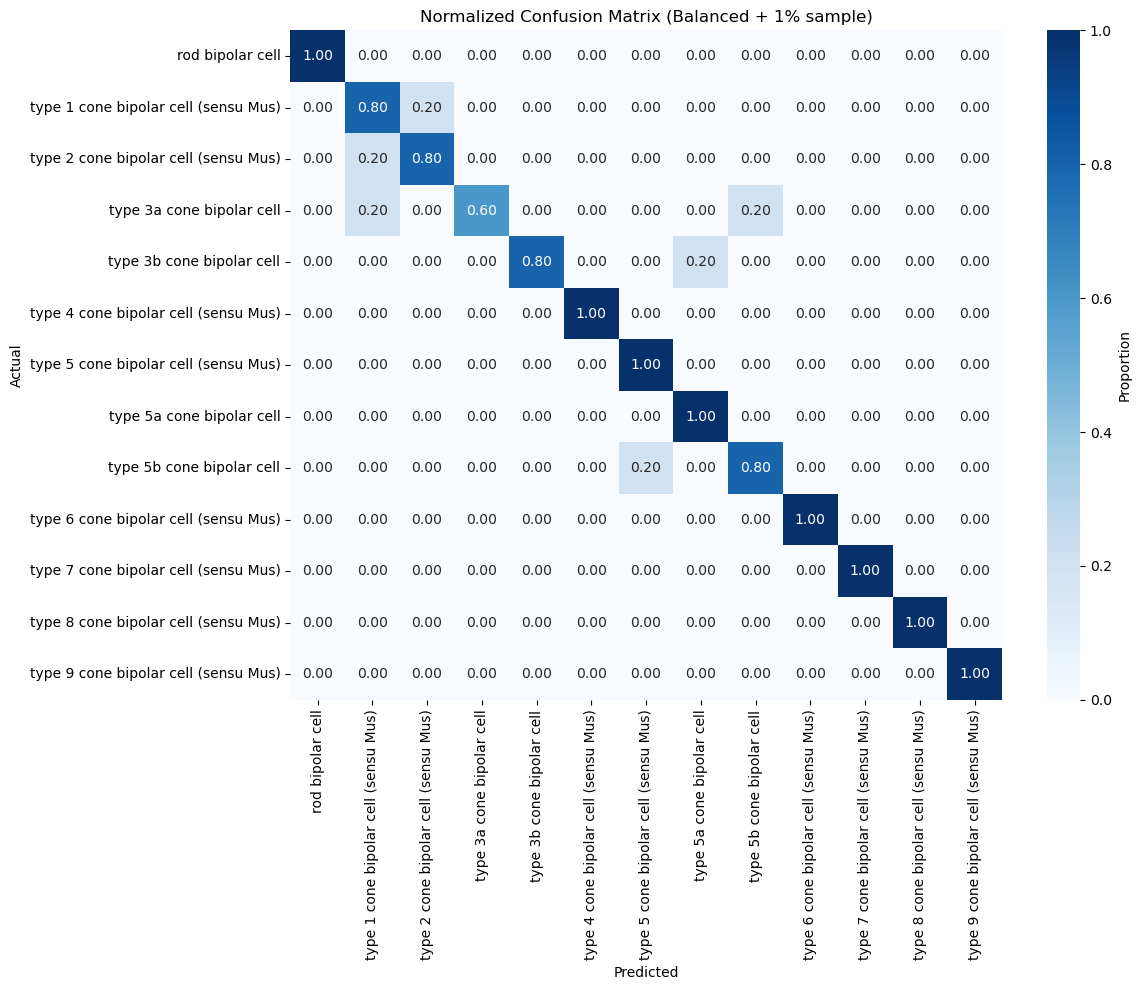

In [8]:
# --- Step 7: Normalized Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,        # show the numbers in the cells
    fmt=".2f",         # two decimal places, e.g. 0.40
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Blues",
    cbar_kws={'label': 'Proportion'}
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix (Balanced + 1% sample)")
plt.tight_layout()
plt.show()